In [10]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import praw


In [11]:

reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='')

In [12]:
headlines = set()

In [13]:
for submissions in reddit.subreddit('politics').new(limit=None):
    headlines.add(submissions.title)
    display.clear_output()
    print(len(headlines))

974


In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
sia = SIA()
results = []
for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
pprint(results[:3], width=100)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rama/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[{'compound': 0.0258,
  'headline': 'Markey Bill, Backed by Sanders and Warren, Moves to Abolish Qualified Immunity for '
              "Cops 'Once-and-for-All'",
  'neg': 0.0,
  'neu': 0.927,
  'pos': 0.073},
 {'compound': 0.0,
  'headline': "U.S. Is 'Out of Control' Under Trump, 75 Percent of Americans Think: Poll",
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'Secret Service agents preparing for Pence Arizona trip contracted coronavirus',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


In [18]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.0,0.927,0.073,0.0258,"Markey Bill, Backed by Sanders and Warren, Mov..."
1,0.0,1.000,0.000,0.0000,"U.S. Is 'Out of Control' Under Trump, 75 Perce..."
2,0.0,1.000,0.000,0.0000,Secret Service agents preparing for Pence Ariz...
3,0.0,1.000,0.000,0.0000,Former GOP presidential candidate Herman Cain ...
4,0.0,1.000,0.000,0.0000,Proposed HUD rule rolls back Obama-era protect...


In [19]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,neg,neu,pos,compound,headline,label
0,0.0,0.927,0.073,0.0258,"Markey Bill, Backed by Sanders and Warren, Mov...",0
1,0.0,1.000,0.000,0.0000,"U.S. Is 'Out of Control' Under Trump, 75 Perce...",0
2,0.0,1.000,0.000,0.0000,Secret Service agents preparing for Pence Ariz...,0
3,0.0,1.000,0.000,0.0000,Former GOP presidential candidate Herman Cain ...,0
4,0.0,1.000,0.000,0.0000,Proposed HUD rule rolls back Obama-era protect...,0


In [20]:
df2 = df[['headline', 'label']]
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)


In [21]:
print("Positive headlines:\n")
pprint(list(df[df['label']==1].headline)[:5], width=200)

print("\n Negative headlines:\n")
pprint(list(df[df['label']== -1].headline)[:5], width=200)

Positive headlines:

["Bolton: 'I have enough scars' from bringing up Russia-related intelligence with Trump",
 'Troops sent to DC during George Floyd protests had bayonets, top general says | Some troops sent to Washington did not have riot response training, Associated Press finds',
 'You can support your country or Trump, but not both',
 "Kimberly Guilfoyle, Trump campaign official and girlfriend of president's son, tests positive for coronavirus",
 'GOP senators propose swapping Columbus Day with Juneteenth as federal holiday']

 Negative headlines:

['Pence Postponed Arizona Trip After Secret Service Agents Showed Signs of Virus',
 'America Is Done With Trump, and Stupid Cruel Tough Guy Acts',
 'GOP’s refusal to take election security measures undermines its fraud claims',
 'Trump tries to drag America backward on a very different July 4th',
 'Why is Trump Turning a Blind Eye to Russia’s Covert Warfare?']


In [22]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 0    419
-1    346
 1    209
Name: label, dtype: int64
 0    43.018480
-1    35.523614
 1    21.457906
Name: label, dtype: float64


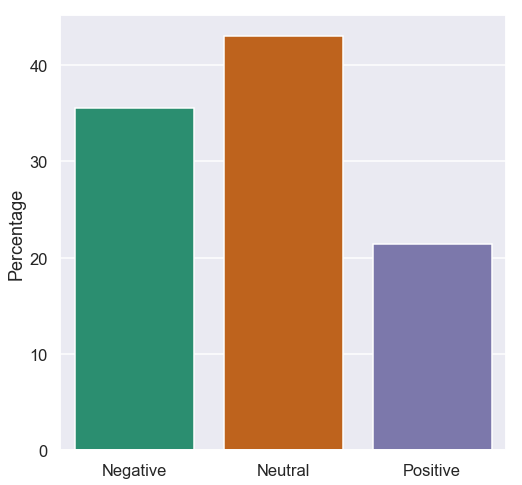

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Percentage')

plt.show()

In [25]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
nltk.download('punkt')

example = "This is an example sentence! However, it ain't a proper one. "

print(word_tokenize(example, language='english'))

[nltk_data] Downloading package punkt to /home/rama/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'ai', "n't", 'a', 'proper', 'one', '.']


In [34]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 'However',
 'it',
 'ain',
 't',
 'a',
 'proper',
 'one']

In [35]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [36]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    return tokens

In [37]:
pos_lines = list(df[df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('trump', 86),
 ('coronavirus', 24),
 ('court', 24),
 ('supreme', 22),
 ('biden', 21),
 ('us', 16),
 ('new', 14),
 ('positive', 13),
 ('u', 13),
 ('top', 12),
 ('covid', 12),
 ('donald', 11),
 ('would', 11),
 ('19', 11),
 ('tests', 10),
 ('says', 9),
 ('kimberly', 9),
 ('cases', 9),
 ('mueller', 9),
 ('voting', 9)]

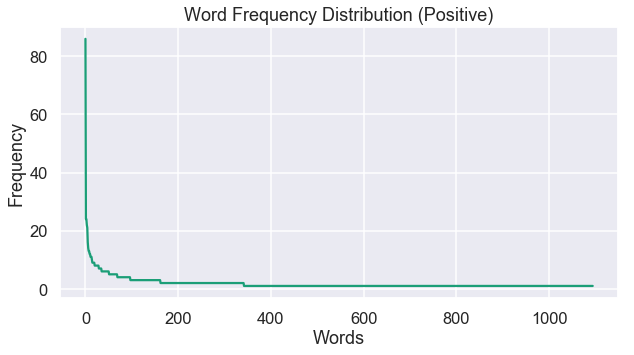

In [38]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

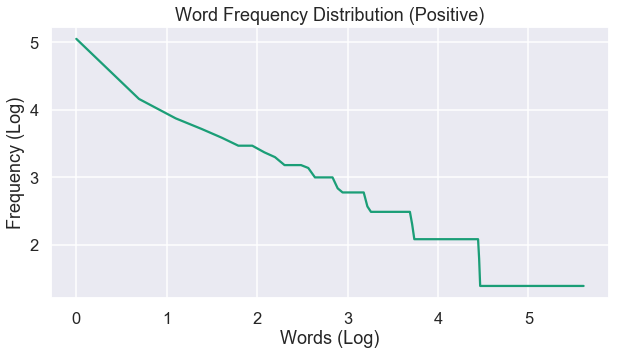

In [41]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i+k+z+t))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [42]:
neg_lines = list(df2[df2.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 176),
 ('rushmore', 29),
 ('coronavirus', 27),
 ('says', 26),
 ('us', 21),
 ('mount', 19),
 ('house', 19),
 ('president', 18),
 ('pandemic', 18),
 ('biden', 18),
 ('campaign', 17),
 ('new', 16),
 ('u', 16),
 ('white', 15),
 ('racist', 15),
 ('america', 14),
 ('covid', 14),
 ('people', 14),
 ('election', 13),
 ('19', 12)]

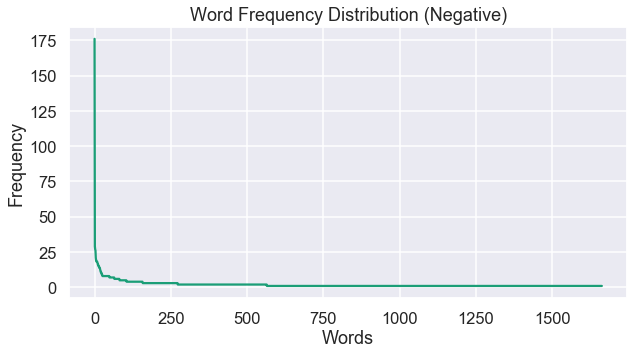

In [44]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()



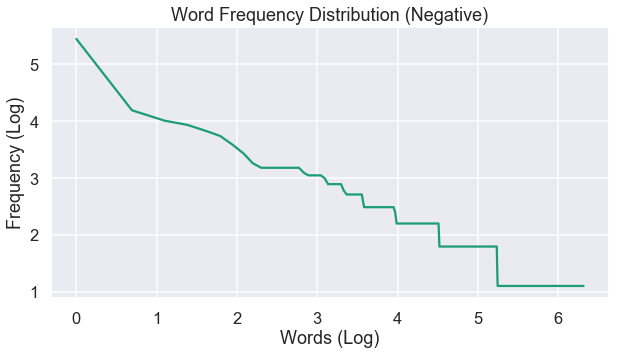

In [45]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()